In [1]:



!pip install transformers sentence-transformers pgvector psycopg2 numpy matplotlib numba pymupdf

  Using cached transformers-4.46.1-py3-none-any.whl.metadata (44 kB)
  Using cached sentence_transformers-3.2.1-py3-none-any.whl.metadata (10 kB)
  Using cached pgvector-0.3.6-py3-none-any.whl.metadata (13 kB)
  Using cached psycopg2-2.9.10-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
  Using cached numpy-2.1.2-cp312-cp312-win_amd64.whl.metadata (59 kB)
  Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached numba-0.60.0-cp312-cp312-win_amd64.whl.metadata (2.8 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached huggingface_hub-0.26.2-py3-none-any.whl.metadata (13 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
  Using cached regex-2024.9.11-cp312-cp312-win_amd64.whl.metadata (41 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached safetensors-0.4.5-cp312-none-win_amd64.whl.metadata (3.9 kB)
  Using cached tokenizers-0.20.1-cp312-none-win_amd64.whl.metadata (6.9 


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Testing dei vari modelli di embeddings su frasi con contesto postivio o contesto negativo

In [11]:
from numba import jit
import numpy as np



@jit(nopython=True)
def cosine_similarity(A, B):
    dot_product = 0.0
    norm_A = 0.0
    norm_B = 0.0
    
    for i in range(len(A)):
        dot_product += A[i] * B[i]
        norm_A += A[i] * A[i]
        norm_B += B[i] * B[i]
    
    return dot_product / (np.sqrt(norm_A) * np.sqrt(norm_B))

In [79]:
from sentence_transformers import SentenceTransformer
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

# Lista espansa di coppie di frasi in italiano (testi più complessi)
text_pairs = [
    # Pairs with Shared Context (First 8 Pairs)
    (
        "Il sole splende alto nel cielo azzurro. Gli uccelli cinguettano felici. È una giornata perfetta per una passeggiata al parco.",
        "Oggi è una giornata meravigliosa. Il cielo è limpido e azzurro. Perfetta per una passeggiata al parco."
    ),
    (
        "La pizza margherita è una delle più amate in Italia. È fatta con pomodoro, mozzarella e basilico. Molti italiani la preferiscono con mozzarella di bufala.",
        "La pizza margherita è molto popolare in Italia. Gli ingredienti principali sono pomodoro, mozzarella e basilico. Alcuni preferiscono usare mozzarella di bufala."
    ),
    (
        "Il Colosseo è uno dei monumenti più famosi di Roma. Ogni anno, milioni di turisti lo visitano. È un simbolo dell'antica Roma.",
        "Il Colosseo è una delle attrazioni principali di Roma. Milioni di turisti lo visitano ogni anno. Rappresenta la grandezza dell'antica Roma."
    ),
    (
        "Il calcio è lo sport più popolare in Italia. Le partite di Serie A attirano molti spettatori. I tifosi sono molto appassionati.",
        "In Italia, il calcio è lo sport nazionale. Le partite di Serie A sono seguite da molti tifosi. La passione per il calcio è enorme."
    ),
    (
        "La pasta è un alimento base nella cucina italiana. Ci sono molti tipi di pasta, come spaghetti e penne. È spesso servita con vari tipi di sugo.",
        "In Italia, la pasta è un piatto fondamentale. Esistono diversi tipi di pasta, come spaghetti e penne. Viene solitamente accompagnata da vari sughi."
    ),
    (
        "Il vino italiano è famoso in tutto il mondo. Le regioni vinicole come la Toscana producono vini eccellenti. Molti turisti visitano l'Italia per degustare il vino.",
        "L'Italia è rinomata per il suo vino. Regioni come la Toscana sono celebri per la produzione di vini di alta qualità. I turisti amano visitare queste regioni per le degustazioni."
    ),
    (
        "La moda italiana è conosciuta per la sua eleganza. Milano è una delle capitali mondiali della moda. Molti stilisti famosi sono italiani.",
        "L'Italia è famosa per la sua moda elegante. Milano è considerata una delle capitali della moda. Numerosi stilisti di fama internazionale sono italiani."
    ),
    (
        "La cucina italiana è apprezzata in tutto il mondo. Piatti come la pasta e la pizza sono molto popolari. Ogni regione ha le sue specialità culinarie.",
        "La cucina italiana è amata globalmente. Piatti come pasta e pizza sono famosi ovunque. Ogni regione italiana offre specialità uniche."
    ),
    
    # Pairs with Different Contexts (Last 7 Pairs)
    (
        "Il sole splende alto nel cielo azzurro. Gli uccelli cinguettano felici. È una giornata perfetta per una passeggiata al parco.",
        "La moda italiana è conosciuta per la sua eleganza. Milano è una delle capitali mondiali della moda. Molti stilisti famosi sono italiani."
    ),
    (
        "La pizza margherita è una delle più amate in Italia. È fatta con pomodoro, mozzarella e basilico. Molti italiani la preferiscono con mozzarella di bufala.",
        "Il vino italiano è famoso in tutto il mondo. Le regioni vinicole come la Toscana producono vini eccellenti. Molti turisti visitano l'Italia per degustare il vino."
    ),
    (
        "Il Colosseo è uno dei monumenti più famosi di Roma. Ogni anno, milioni di turisti lo visitano. È un simbolo dell'antica Roma.",
        "La pasta è un alimento base nella cucina italiana. Ci sono molti tipi di pasta, come spaghetti e penne. È spesso servita con vari tipi di sugo."
    ),
    (
        "Il calcio è lo sport più popolare in Italia. Le partite di Serie A attirano molti spettatori. I tifosi sono molto appassionati.",
        "La cucina italiana è apprezzata in tutto il mondo. Piatti come la pasta e la pizza sono molto popolari. Ogni regione ha le sue specialità culinarie."
    ),
    (
        "La pasta è un alimento base nella cucina italiana. Ci sono molti tipi di pasta, come spaghetti e penne. È spesso servita con vari tipi di sugo.",
        "Il sole splende alto nel cielo azzurro. Gli uccelli cinguettano felici. È una giornata perfetta per una passeggiata al parco."
    ),
    (
        "Il vino italiano è famoso in tutto il mondo. Le regioni vinicole come la Toscana producono vini eccellenti. Molti turisti visitano l'Italia per degustare il vino.",
        "Il Colosseo è uno dei monumenti più famosi di Roma. Ogni anno, milioni di turisti lo visitano. È un simbolo dell'antica Roma."
    ),
    (
        "La moda italiana è conosciuta per la sua eleganza. Milano è una delle capitali mondiali della moda. Molti stilisti famosi sono italiani.",
        "Il calcio è lo sport più popolare in Italia. Le partite di Serie A attirano molti spettatori. I tifosi sono molto appassionati."
    )
]


# Caricamento dei modelli Sentence Transformers
# per aggiungere altro modello models['NuovoModello'] = SentenceTransformer('nome-del-modello')
models = {
    #https://huggingface.co/nickprock/sentence-bert-base-italian-uncased
    'SBBIU (Sentence Italian BERT)': SentenceTransformer("nickprock/sentence-bert-base-italian-uncased"),
    #https://huggingface.co/nickprock/sentence-bert-base-italian-xxl-uncased
    'SBBIU (Sentence Italian BERT XXL)': SentenceTransformer("nickprock/sentence-bert-base-italian-xxl-uncased"),
    #https://huggingface.co/dbmdz/bert-base-italian-cased
    'Base-Bert(Italian BERT base)': SentenceTransformer("dbmdz/bert-base-italian-cased"),
    #https://huggingface.co/dbmdz/bert-base-italian-cased
    'Base-Bert(Italian BERT XXL)': SentenceTransformer("dbmdz/bert-base-italian-xxl-cased"),
    #https://huggingface.co/indigo-ai/BERTino
    'BERTino (Italian GPT2)': SentenceTransformer("efederici/sentence-BERTino"),
}

# Funzione per valutare la similarità coseno basata su un modello e coppie di frasi
def evaluate_cosine_similarity(model, sentence_pairs):
    """
    Valuta la similarità coseno tra coppie di frasi utilizzando un modello di embedding.

    Args:
    - model: Modello pre-addestrato per generare embeddings.
    - sentence_pairs: Lista di tuple contenenti coppie di frasi (frase1, frase  2).

    Returns:
    - similarities: Lista di valori di similarità coseno tra le coppie di frasi.
    """
    similarities = []
    for sentence1, sentence2 in sentence_pairs:
        # Genera gli embeddings per entrambe le frasi della coppia
        embeddings = model.encode([sentence1, sentence2])
        
        A = np.array(embeddings[0], dtype=np.float32)
        B = np.array(embeddings[1], dtype=np.float32)
        # Calcola la similarità coseno tra gli embeddings delle due frasi aggiugnednola alla lista delle similarita
        similarities.append(cosine_similarity(A,B))
    return similarities

# Valutazione delle similarità per tutti i modelli
all_similarities = {
    model_name: evaluate_cosine_similarity(model, text_pairs)
    for model_name, model in models.items()
}


No sentence-transformers model found with name dbmdz/bert-base-italian-cased. Creating a new one with mean pooling.
No sentence-transformers model found with name dbmdz/bert-base-italian-xxl-cased. Creating a new one with mean pooling.


In [6]:
!pip install pandas -q


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [80]:
import pandas as pd

def print_statistics(similarities_dict, csv_filename='similarities_statistics.csv'):
    """
    Calcola le statistiche di base sulle similarità coseno e salva in un file CSV.

    Args:
    - similarities_dict: Dizionario con chiavi come nomi dei modelli e valori come liste di similarità.
    - csv_filename: Nome del file CSV in cui salvare le statistiche.
    """
    
    
    
    # Creazione di un DataFrame per raccogliere le statistiche
    stats_data = {
        'Modello': [],
        'Media Similarità': [],
        'Minima Similarità': [],
        'Massima Similarità': []
    }

    # Calcolo delle statistiche e popolamento del DataFrame
    for model_name, similarities in similarities_dict.items():
        stats_data['Modello'].append(model_name)
        stats_data['Media Similarità'].append(np.mean(similarities))
        stats_data['Minima Similarità'].append(np.min(similarities))
        stats_data['Massima Similarità'].append(np.max(similarities))

    # Creazione del DataFrame
    stats_df = pd.DataFrame(stats_data)

    # Salvataggio del DataFrame in un file CSV
    stats_df.to_csv(csv_filename, index=False)

    # Caricamento del CSV in un nuovo DataFrame e stampa
    loaded_df = pd.read_csv(csv_filename)
    
    display(loaded_df)

,Modello,Media Similarità,Minima Similarità,Massima Similarità
0,SBBIU (Sentence Italian BERT),0.639119,0.138966,0.965006
1,SBBIU (Sentence Italian BERT XXL),0.650895,0.192090,0.973379
2,Base-Bert(Italian BERT base),0.893100,0.807381,0.974789
3,Base-Bert(Italian BERT XXL),0.814302,0.636106,0.954791
4,BERTino (Italian GPT2),0.596993,0.048745,0.975446


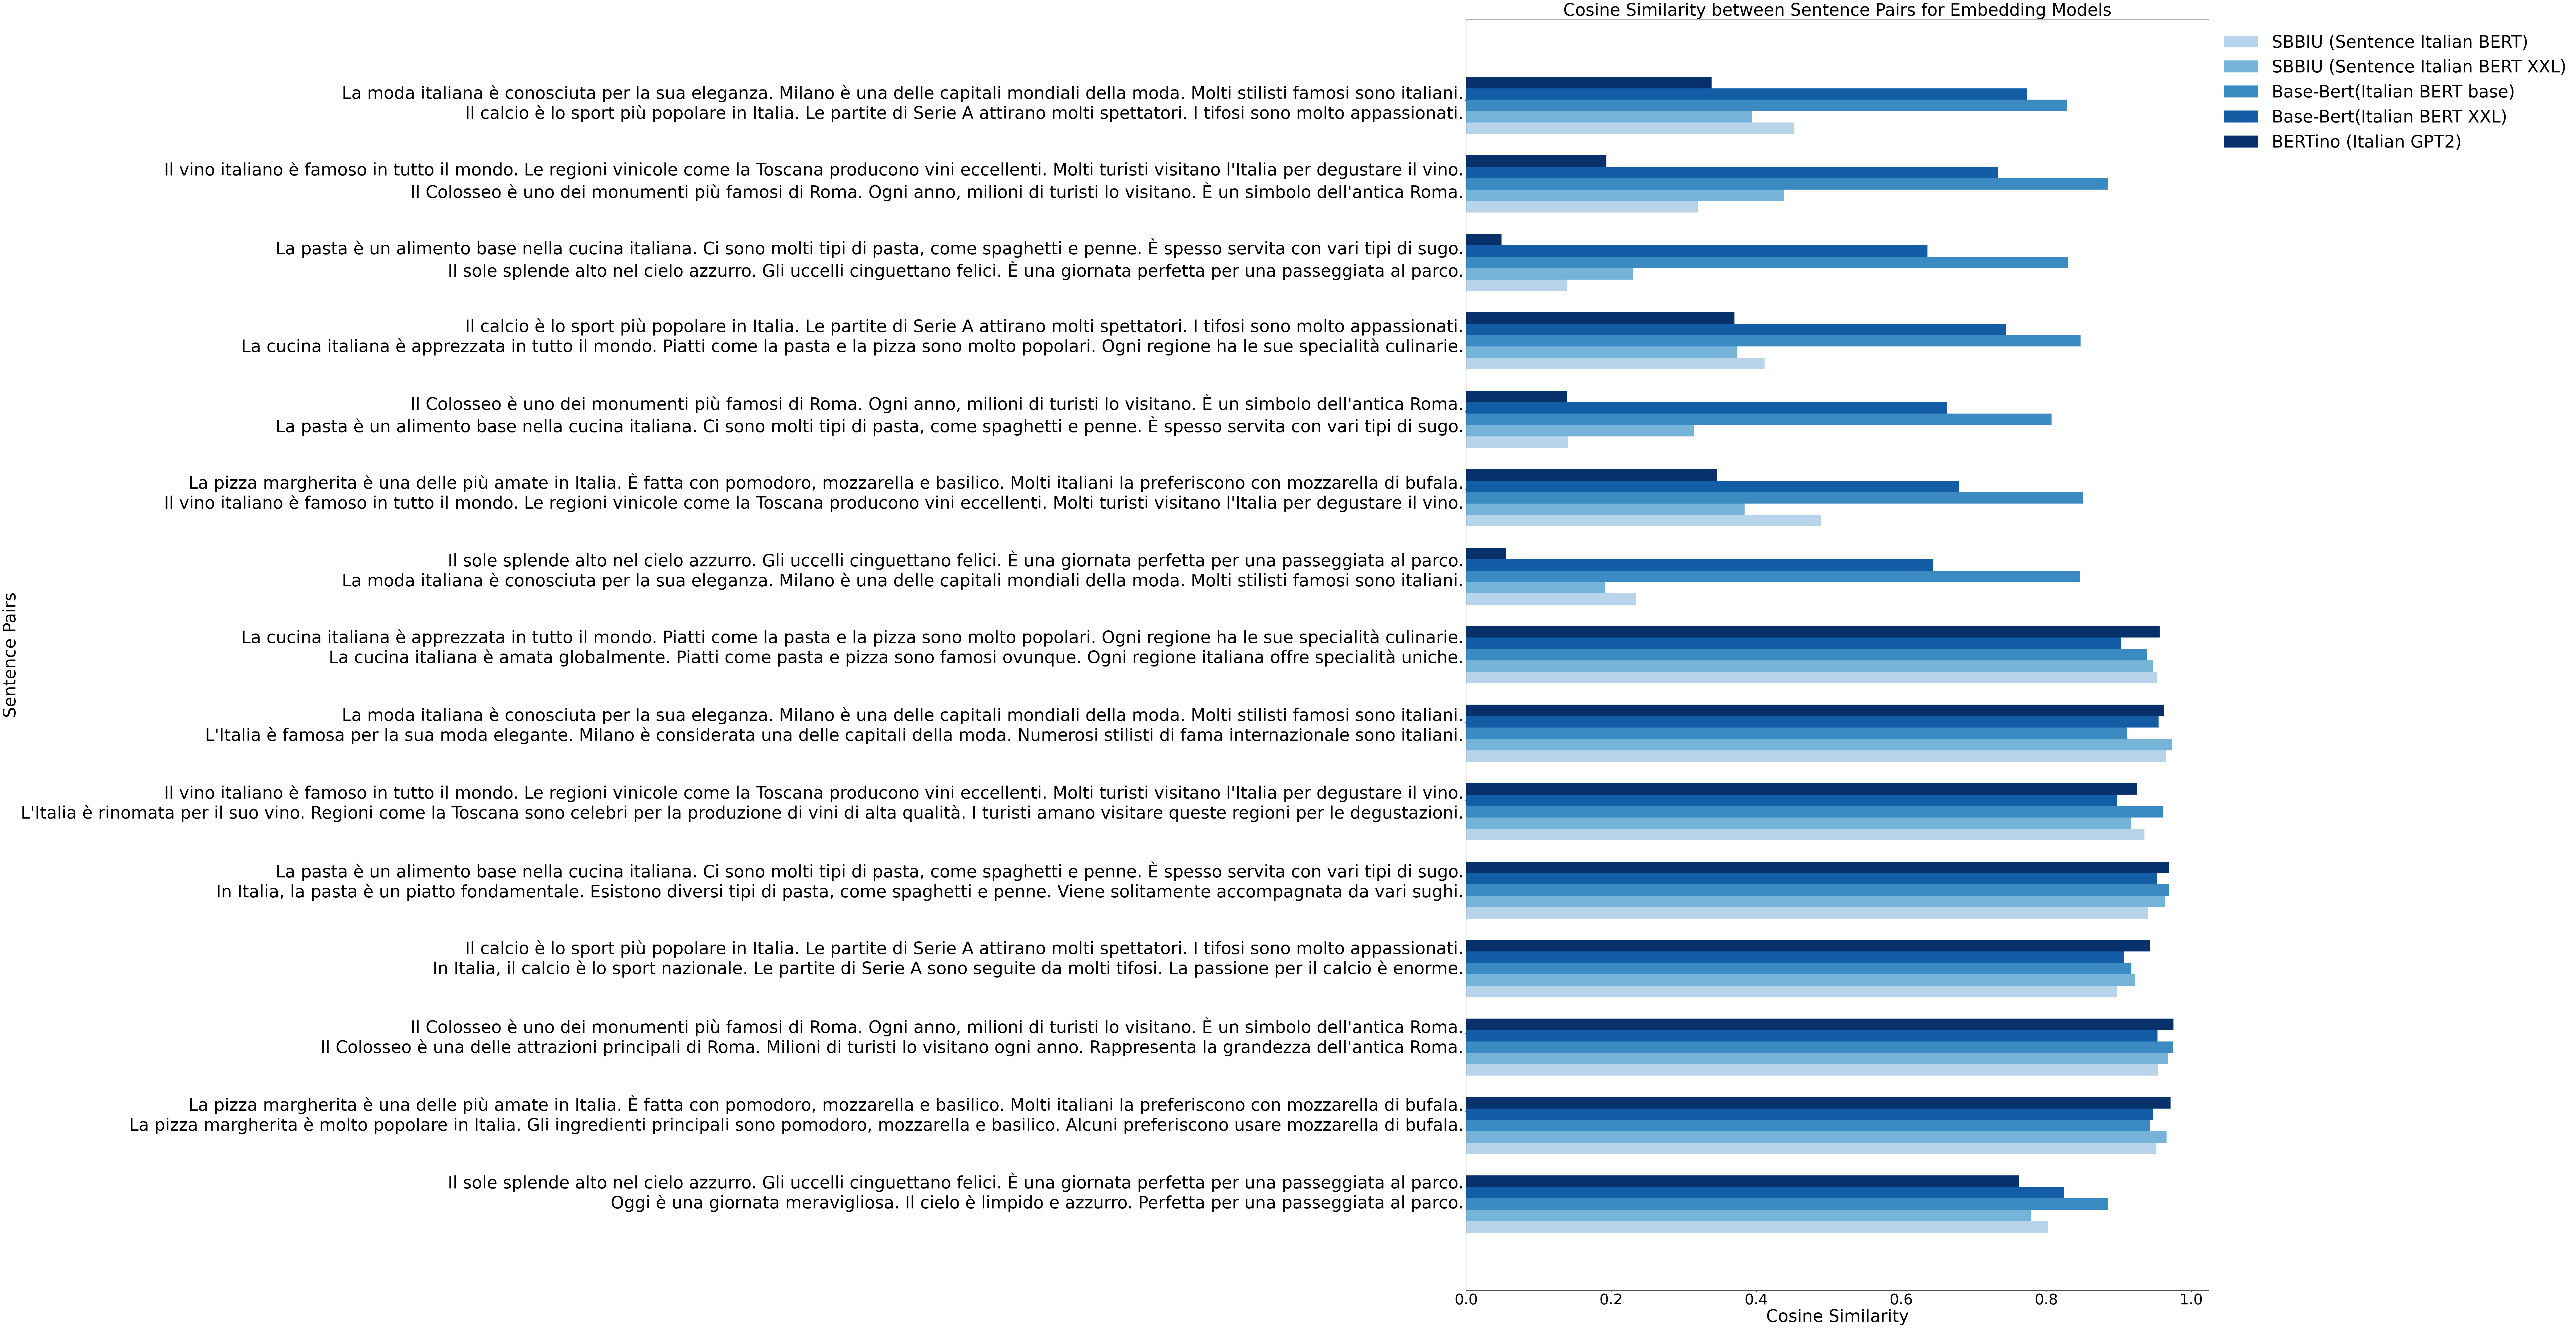

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


# Funzione per visualizzare i risultati utilizzando matplotlib
def plot_similarities(all_similarities):
    """
    Crea un grafico a barre orizzontali che mostra le similarità coseno tra coppie di frasi
    per più modelli di embedding.

    Args:
    - all_similarities: Dizionario contenente i valori di similarità per diversi modelli.
    - sentences_pairs: Lista di coppie di frasi.
    """
    labels = [f"{a[0]}\n{a[1]}" for a in text_pairs]  # Show sentence pairs vertically
    y = np.arange(len(labels))  # Positions along the y-axis
    
    width = 0.8  # Width of the bars

    # Set dark background style
    plt.figure(figsize=(36, 62))  # Set the size of the figure
    
    colors = plt.cm.Blues(np.linspace(0.3, 1, len(all_similarities)))
    
    # Plot bars for each model's similarities
    for i, (model_name, similarities) in enumerate(all_similarities.items()):
        plt.barh(y * 5.5 + ((width * (i + 1)) + 2), similarities, height=width, label=model_name, color=colors[i % len(colors)])

    # Add an extra empty label for spacing
    labels.append("")
    labels.insert(0, "")
    y = np.append(y, np.array(len(labels) - 2))
    y = np.append(y, np.array(len(labels) - 1))
    
    # Customize labels and chart elements
    plt.xlabel("Cosine Similarity", fontsize=46,)
    plt.ylabel("Sentence Pairs", fontsize=46,)
    plt.title("Cosine Similarity between Sentence Pairs for Embedding Models", fontsize=46)
    plt.yticks(y * 5.45, labels, fontsize=46)  # Apply the same color scheme to the labels
    plt.xticks(fontsize=40)  # Make sure x-axis ticks are also visible

    # Customize the legend
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=46, frameon=False)
    
    # Show the plot
    plt.show()
    
    
    
# Visualizzazione delle similarità
print_statistics(all_similarities)
plot_similarities(all_similarities)


In [2]:
import fitz  # PyMuPDF
import re

import numpy as np
import pandas as pd

import textwrap



def extract_subtitles_and_text(pdf_path, start_page=0):
    """
    Estrae i sottotitoli e il testo corrispondente da un file PDF a partire da una pagina specifica.

    Parametri:
    pdf_path (str): Il percorso del file PDF da analizzare.
    start_page (int): Il numero della pagina da cui iniziare l'estrazione (0 per la prima pagina).

    Ritorna:
    dict: Un dizionario dove le chiavi sono gli indici dei sottotitoli (es. 1.1, 2.3) e i valori sono tuple con il nome del sottocapitolo e il testo corrispondente.
    """
    # Apri il file PDF
    document = fitz.open(pdf_path)
    
    # Inizializza un dizionario vuoto per memorizzare i sottotitoli e il testo corrispondente
    subtitles_dict = {}
    
    # Definisci il pattern per trovare i sottotitoli (es. 1.1, 2.3, ecc.)
    pattern = re.compile(r'\d+\.\d+')
    
    current_subtitle = None
    current_subtitle_name = None
    current_text = ""
    
    # Itera attraverso ogni pagina del PDF a partire da start_page
    for page_num in range(start_page, len(document)):
        page = document.load_page(page_num)
        text = page.get_text("text")
        
        lines = text.split('\n')
        
        for i, line in enumerate(lines):
            if pattern.match(line.strip()):
                if current_subtitle:
                    subtitles_dict[current_subtitle] = (current_subtitle_name.replace(".",""), re.sub(r'\d+', '', current_text).strip())
                current_subtitle = line.strip().split()[0]  # Solo l'indice del sottotitolo
                # Controlla se il nome del sottotitolo è sulla stessa riga o sulla riga successiva
                if len(line.strip().split()) > 1:
                    current_subtitle_name = ' '.join(line.strip().split()[1:])
                else:
                    current_subtitle_name = lines[i + 1].strip() if i + 1 < len(lines) else ""
                current_text = ""
            elif line.strip() != current_subtitle_name:
                current_text += " " + line.strip()
        
        if current_subtitle:
            subtitles_dict[current_subtitle] = (current_subtitle_name.replace(".",""), re.sub(r'\d+', '', current_text).strip())
    
    return subtitles_dict

# Esempio di utilizzo
pdf_path = r"D:\Tirocinio\Documenti\ManualeTETRAS_modificato2.pdf"
subtitles_dict = extract_subtitles_and_text(pdf_path)

# Stampa i sottotitoli estratti e il testo corrispondente
for subtitle, text in subtitles_dict.items():
    print(f"Index:{subtitle}.\nName:{text[0]}\nContains {len(text[1])} charater:\n\n{textwrap.fill(text[1], width=50)}\n\n")





Index:4.2.
Name:Indagini Le Funzionalità
Contains 139 charater:

Dopo aver effettuato l’accesso a TETRAS  l’utente
si troverà sempre sull’indagine predefinita con la
visualizzazione della Scheda Indagine.


Index:4.3.
Name:Indagini: funzionalità crea nuova indagine
Contains 571 charater:

Se è la prima volta che si accede, su una nuova
installazione Client/Server, l’utente troverà le
caselle per la creazione di una nuova indagine:
Il nome è obbligatorio, la descrizione è
facoltativa. Dopo aver inserito le informazioni
(ad esempio Nome – Evento criminoso, Descrizione –
Indagine su un reato) cliccare su Crea una nuova
indagine.     L’utente sarà direzionato sulla
Scheda Indagine, all’interno della macro-sessione
Analisi e la nuova indagine diviene
automaticamente l’Indagine Predefinita. Da questo
momento in poi TETRAS  si aprirà su questa
indagine.


Index:4.4.
Name:Indagini: funzionalità indagine corrente
Contains 583 charater:

Se l’utente, su un Client/Server già utilizzato,
clicca su

In [ ]:
#subtitles_dict.pop("4.2")


countOfchar = []

for subtitle, text in subtitles_dict.items():
    countOfchar.append(len(text[1]))


for subtitle, text in subtitles_dict.items():
    print(f"Index:{subtitle}.\nName:{text[0]}\nContains {len(text[1])} charater:\n\n{textwrap.fill(text[1], width=50)}\n\n")
    
    
mean = np.mean(np.array(countOfchar))
min = np.min(np.array(countOfchar))
max = np.max(np.array(countOfchar))

stats_data = {
    'Media': mean,
    'Minimo': min,
    'Massimo': max
}    

pandas_df = pd.DataFrame(stats_data, index=[0])

display(pandas_df)


Index:4.3.
Name:Indagini: funzionalità crea nuova indagine
Contains 571 charater:

Se è la prima volta che si accede, su una nuova
installazione Client/Server, l’utente troverà le
caselle per la creazione di una nuova indagine:
Il nome è obbligatorio, la descrizione è
facoltativa. Dopo aver inserito le informazioni
(ad esempio Nome – Evento criminoso, Descrizione –
Indagine su un reato) cliccare su Crea una nuova
indagine.     L’utente sarà direzionato sulla
Scheda Indagine, all’interno della macro-sessione
Analisi e la nuova indagine diviene
automaticamente l’Indagine Predefinita. Da questo
momento in poi TETRAS  si aprirà su questa
indagine.


Index:4.4.
Name:Indagini: funzionalità indagine corrente
Contains 583 charater:

Se l’utente, su un Client/Server già utilizzato,
clicca sulla voce Indagini nella barra di sinistra
verrà mostrata la pagina Seleziona Indagine con
l’elenco delle Indagini disponibili tra cui
scegliere la predefinita:    Selezionare
l’indagine di interesse nell’ele

,Media,Minimo,Massimo
0,2643.907407,323,19221


Testing di possibile implementazione di un database vettoriale che permetta la memorizzazione del testo sezionato in chunk sfruttando il concetto di vettore e indicizazzione degli embeddings.


Utilizzo di psycopg2 per la connessione al db

In [ ]:
%store subtitles_dict
#%store -r subtitles_dict

Stored 'subtitles_dict' (dict)


d:\Tirocinio\PythonFiles\DocumentalRag\.venv_DocumentalRag\Lib\site-packages\IPython\extensions\storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/subtitles_dict requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj


In [ ]:
from langchain.text_splitter import TokenTextSplitter


def chunk(text, chunk_size=512, chunk_overlap=20):
    """
    Divide un testo in chunk di dimensione fissa con un certo overlap.

    Args:
    - text (str): Il testo da dividere in chunk.
    - chunk_size (int): La dimensione di ciascun chunk.
    - chunk_overlap (int): L'overlap tra i chunk.

    Returns:
    - List[str]: Una lista di chunk di dimensione fissa.
    """
    semantic_splitter = TokenTextSplitter(
    chunk_size=chunk_size,    # Number of characters per chunk
    chunk_overlap=chunk_overlap   # Overlap to preserve context
    )

# Split the text into semantic chunks
    chunks = semantic_splitter.split_text(text)
    
    return chunks




Approccio standard, utilizzo chunk di dimensione fissa usando una conversione tra charater a token  di 1 a 4.5 e dimensioni di overlapping variabili 

In [ ]:


# Define chunk sizes and overlap percentages
chunk_size = 1212
overlap_percentages = [0.1, 0.2, 0.3]

# Initialize dictionaries to store results
chunked_subtitles_dict512percent10 = subtitles_dict.copy()
chunked_subtitles_dict512percent20 = subtitles_dict.copy()
chunked_subtitles_dict512percent30 = subtitles_dict.copy()

dictList = [chunked_subtitles_dict512percent10,chunked_subtitles_dict512percent20,chunked_subtitles_dict512percent30]

for subtitle, text in subtitles_dict.items():
        for overlap_percentage,dict in zip(overlap_percentages,dictList):
            overlap = int(chunk_size * overlap_percentage)
            if len(text[1]) <= chunk_size:
                dict[subtitle] = [text[1]]
            else:
                dict[subtitle] = chunk(text[1], chunk_size=chunk_size, chunk_overlap=overlap)


for overlap_percentage, dict in zip(overlap_percentages, dictList):
    overlap_key = int(overlap_percentage * 100)
    print(f"Chunks with size {chunk_size} and {overlap_key}% overlap:")
    for subtitle, chunks in dict.items():
        print(f"Subtitle: {subtitle}")
        for chunk in chunks:
            print(chunk)
            print("\n")


Chunks with size 1786 and 10% overlap:
Subtitle: 4.3
Se è la prima volta che si accede, su una nuova installazione Client/Server, l’utente troverà le caselle per la creazione di una nuova indagine:    Il nome è obbligatorio, la descrizione è facoltativa. Dopo aver inserito le informazioni (ad esempio Nome – Evento criminoso, Descrizione – Indagine su un reato) cliccare su Crea una nuova indagine.     L’utente sarà direzionato sulla Scheda Indagine, all’interno della macro-sessione Analisi e la nuova indagine diviene automaticamente l’Indagine Predefinita. Da questo momento in poi TETRAS  si aprirà su questa indagine.


Subtitle: 4.4
Se l’utente, su un Client/Server già utilizzato, clicca sulla voce Indagini nella barra di sinistra verrà mostrata la pagina Seleziona Indagine con l’elenco delle Indagini disponibili tra cui scegliere la predefinita:    Selezionare l’indagine di interesse nell’elenco, manualmente o cercandola con la casella di testo Ricerca Testo Completo e cliccare su Ind

In [ ]:

from langchain import SQLDatabase



def get_connection_to_SQLDatabase(host="localhost", data_base_name="database" , username="postgres", password="postgres", port="5432"):
    g_uri = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{data_base_name}"
    return SQLDatabase.from_uri(g_uri)

db1 = get_connection_to_SQLDatabase(host="localhost",data_base_name="DBTestChunking1",username="postgres",password="578366")

db2 = get_connection_to_SQLDatabase(host="localhost",data_base_name="DBTestChunking2",username="postgres",password="578366")

db3 = get_connection_to_SQLDatabase(host="localhost",data_base_name="DBTestChunking3",username="postgres",password="578366")

db4 = get_connection_to_SQLDatabase(host="localhost",data_base_name="DBTestQueries",username="postgres",password="578366")



dbsChunking = [db1,db2,db3] 



#caricamento base della struttura del db + generazione estensione che usa pgvectorscale
#(vector type, permette query di ricerca direttamentte sugli embeddings) 


for db in dbsChunking:
    db.run("CREATE EXTENSION IF NOT EXISTS vectorscale CASCADE;")
    
    db.run("""
    DO $$
    BEGIN
        IF NOT EXISTS (SELECT 1 FROM pg_tables WHERE tablename = 'documents') THEN
            CREATE TABLE documents (
                id BIGINT PRIMARY KEY GENERATED BY DEFAULT AS IDENTITY,
                content TEXT NOT NULL,
                index TEXT NOT NULL,
                embedding VECTOR(768) NOT NULL
            );
            
            CREATE INDEX document_embedding_idx ON documents
            USING diskann (embedding);
        END IF;
    END $$;
    """)
    
model = SentenceTransformer("efederici/sentence-BERTino")

for db, dict in zip(dbsChunking, dictList):
    for subtitle, chunks in dict.items():
        embeddings = model.encode(chunks)
        for chunk, embedding in zip(chunks, embeddings):
            db.run("INSERT INTO documents (content, index, embedding) VALUES (%s, %s, %s);", (chunk, subtitle, embedding.tolist()))

In [ ]:
from sentence_transformers import SentenceTransformer
import time


model = SentenceTransformer("efederici/sentence-BERTino")

def query_similar_entities_with_similarity(db,query_text, top_k=1):
    # Genera l'embedding della query
    query_embedding = model.encode(query_text)
    
    start_time = time.time()
    # Esegui una ricerca vettoriale sui dati
    results = db.run("""
        SELECT content, 1 - (embedding <=> %s) AS similarity, index
        FROM documents
        ORDER BY embedding <=> %s
        LIMIT %s;
    """, (query_embedding.tolist(), query_embedding.tolist(), top_k))
    elapsed_time = time.time() - start_time

    
    # Convert similarity to percentage
    results_with_percentage = [(content, similarity * 100) for content, similarity in results]
    
    return results_with_percentage,elapsed_time

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define a list of queries and their corresponding ground truth indices
queries = [
    ("Qual è il miglior modo per utilizzare il software TETRAS?", "1.1"),
    ("Come posso configurare le impostazioni di sicurezza in TETRAS?", "2.3"),
    ("Quali sono le funzionalità principali di TETRAS?", "3.2"),
    ("Come posso esportare i dati da TETRAS?", "4.1"),
    ("Quali sono i requisiti di sistema per installare TETRAS?", "5.4")
]

def test_queries(db, queries, top_k=1):
    """
    Test the queries and retrieve information.

    Args:
    - db: The database connection.
    - queries: List of tuples containing query and ground truth index.
    - top_k: Number of top results to retrieve.

    Returns:
    - List of tuples containing query, ground truth index, and result.
    """
    results = []
    for query, ground_truth_index in queries:
        result = query_similar_entities_with_similarity(db, query, top_k)
        results.append((query, ground_truth_index, result))
    return results

def calculate_statistics(query_results, queries):
    """
    Calculate statistics from the query results.

    Args:
    - query_results: List of tuples containing query, ground truth index, and result.
    - queries: List of queries.

    Returns:
    - DataFrame containing the statistics.
    """
    statistics = {
        'Query': [],
        'Ground Truth Index': [],
        'Top Result': [],
        'Similarity (%)': [],
        'Correct': [],
        'Elapsed Time': []
    }

    for query, ground_truth_index, result in query_results:
        for res in result[0]:
            statistics['Query'].append(query)
            statistics['Ground Truth Index'].append(ground_truth_index)
            statistics['Top Result'].append(res[2])
            statistics['Correct'].append(ground_truth_index == res[2])
            statistics['Similarity (%)'].append(res[1])
            statistics['Elapsed Time'].append(result[1])

    stats_df = pd.DataFrame(statistics)
    precision = stats_df['Correct'].sum() / len(stats_df)
    recall = stats_df['Correct'].sum() / len(queries)
    stats_df['Precision'] = precision
    stats_df['Recall'] = recall

    return stats_df

def save_statistics_to_csv(stats_df, csv_filename='query_statistics.csv'):
    """
    Save the statistics DataFrame to a CSV file.

    Args:
    - stats_df: DataFrame containing the statistics.
    - csv_filename: Name of the CSV file.
    """
    stats_df.to_csv(csv_filename, index=False)

def plot_statistics(stats_df):
    """
    Plot the statistics using matplotlib.

    Args:
    - stats_df: DataFrame containing the statistics.
    """
    fig, ax = plt.subplots(2, 1, figsize=(14, 12))

    # Plot similarity percentages with elapsed time on y-axis
    ax[0].barh(stats_df['Query'] + "\n" + "Index: " + stats_df['Ground Truth Index'] + "\n" "Correct: "+ stats_df['Correct'].astype(str) + stats_df['Elapsed Time'].astype(str) + "s", stats_df['Similarity (%)'], color='skyblue')
    ax[0].set_xlabel('Similarity (%)')
    ax[0].set_ylabel('Query')
    ax[0].set_title('Query Similarity Analysis')

    # Plot precision and recall on the second chart
    ax[1].bar(['Precision', 'Recall'], [stats_df['Precision'][0] * 100, stats_df['Recall'][0] * 100], color=['green', 'blue'])
    ax[1].set_ylabel('Percentage')
    ax[1].set_title('Precision and Recall')

    plt.tight_layout()
    plt.show()

def main(db, queries):
    """
    Main function to test queries, calculate statistics, save to CSV, and plot results.

    Args:
    - db: The database connection.
    - queries: List of queries.
    """
    query_results = test_queries(db, queries)
    stats_df = calculate_statistics(query_results, queries)
    save_statistics_to_csv(stats_df)
    plot_statistics(stats_df)
    display(stats_df)

# Run the main function
main(db, queries)


In [ ]:
from transformers import pipeline
from langchain_ollama.llms import OllamaLLM

prompt = """Tu sei l'assistente virtuale per il manuale del software TETRAS.\n
Intergirai solo attraverso la lingua italiana. Prima di rispondere prendi un bel respiro e procedi passo dopo passo, \n
prendenoti il tuo tempo e rispondi alla domanda basandoti sul contesto fornito. \n"""


# Inizializza il modello GPT per il completamento di testo

def generate_answer_based_on_retrieval(query_text,db,modelname="llama3.1:8b"):
    # Prima recupera le entità simili
    content = query_similar_entities_with_similarity(db,query_text)[0]
    
    model = OllamaLLM(model=modelname,base_url="http://192.168.100.149:8537")

    
    rag_pipeline = pipeline("text2text-generation", model)    
    # Poi genera la risposta basata sui dati
    question = f"{query_text}"
    answer = rag_pipeline(f"""System_prompt:{prompt} Question: {question} Context: {content} """)
    print(f"Risposta: {answer[0]['generated_text']}")

# Esempio di domanda


Hybrid search

In [14]:

from langchain import SQLDatabase



def get_connection_to_SQLDatabase(host="localhost", data_base_name="database" , username="postgres", password="postgres", port="5432"):
    g_uri = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{data_base_name}"
    return SQLDatabase.from_uri(g_uri)

dbHybrid = get_connection_to_SQLDatabase(host="localhost",data_base_name="DBTestHybrid",username="postgres",password="578366")





#caricamento base della struttura del db + generazione estensione che usa pgvectorscale
#(vector type, permette query di ricerca direttamentte sugli embeddings) 

dbHybrid.run("""
    CREATE EXTENSION IF NOT EXISTS vectorscale CASCADE;
    CREATE TABLE document (
    chunk_id INT PRIMARY KEY,
    content TEXT,
    index TEXT
    );

    CREATE TABLE small_chunks (
    small_chunk_id SERIAL PRIMARY KEY,
    large_chunk_id INTEGER REFERENCES document(chunk_id),
    embedding vector(128)  -- pgvector type
    );
        
    CREATE INDEX document_embedding_idx ON small_chunks
    USING diskann (embedding);
        
    """)

''

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Primary chunks for context
large_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512,
)

# Secondary smaller chunks for better matching
small_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=128,
    chunk_overlap=10
)



In [ ]:
# Create a copy of the original dictionary
chunked_subtitles_dict = subtitles_dict.copy()

# Iterate through the dictionary and generate large and small chunks
for subtitle, text in subtitles_dict.items():
    document = large_splitter.split_text(text[1])
    chunked_subtitles_dict[subtitle] = [(large_chunk, small_splitter.split_text(large_chunk)) for large_chunk in document]

# Print the results
for subtitle, chunks in chunked_subtitles_dict.items():
    print(f"Subtitle: {subtitle}")
    for large_chunk, small_chunks in chunks:
        print(f"Large Chunk: {large_chunk}")
        print("Small Chunks:")
        for small_chunk in small_chunks:
            print(small_chunk + "|")
        print("\n")
        
%store chunked_subtitles_dict

Subtitle: 4.3
Large Chunk: Se è la prima volta che si accede, su una nuova installazione Client/Server, l’utente troverà le caselle per la creazione di una nuova indagine:    Il nome è obbligatorio, la descrizione è facoltativa. Dopo aver inserito le informazioni (ad esempio Nome – Evento criminoso, Descrizione – Indagine su un reato) cliccare su Crea una nuova indagine.     L’utente sarà direzionato sulla Scheda Indagine, all’interno della macro-sessione Analisi e la nuova indagine diviene automaticamente l’Indagine Predefinita. Da questo momento in poi TETRAS  si aprirà su questa indagine.
Small Chunks:
Se è la prima volta che si accede, su una nuova installazione Client/Server, l’utente troverà le caselle per la creazione di una nuova indagine:    Il nome è obbligatorio, la descrizione è facoltativa. Dopo aver inserito le informazioni (ad esempio Nome – Evento criminoso, Descrizione – Indagine su un reato) cliccare su Crea una nuova indagine.|
nuova indagine.     L’utente sarà direz

d:\Tirocinio\PythonFiles\DocumentalRag\.venv_DocumentalRag\Lib\site-packages\IPython\extensions\storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/chunked_subtitles_dict requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj


In [ ]:
model = SentenceTransformer("efederici/sentence-BERTino")

def insert_data_into_sql_tables(db, chunked_subtitles_dict, model):
    """
    Insert the data into the SQL tables.

    Args:
    - db: The database connection.
    - chunked_subtitles_dict: Dictionary containing the chunked subtitles.
    - model: The SentenceTransformer model for generating embeddings.
    """
    for subtitle, chunks in chunked_subtitles_dict.items():
        for large_chunk, small_chunks in chunks:
            # Insert large chunk into document table
            large_chunk_id = db.run("INSERT INTO document (content, index) VALUES (%s, %s) RETURNING chunk_id;", (large_chunk, subtitle))[0][0]
            
            for small_chunk in small_chunks:
                # Generate embedding for the small chunk
                embedding = model.encode(small_chunk)
                
                # Insert small chunk into small_chunks table
                db.run("INSERT INTO small_chunks (large_chunk_id, embedding) VALUES (%s, %s);",
                (large_chunk_id, embedding.tolist()))

# Call the function
insert_data_into_sql_tables(dbHybrid, chunked_subtitles_dict, model)

In [ ]:
from sentence_transformers import SentenceTransformer
import time

model = SentenceTransformer("efederici/sentence-BERTino")


def semantic_search(db,query_text,top_k=1):
    
    # Genera l'embedding della query
    query_embedding = model.encode(query_text)


    #Esegui una ricerca vettoriale sui dati
    start_time = time.time()
    results = db.run("""
    WITH ranked_matches AS (
        SELECT 
            sc.small_chunk_id,
            sc.large_chunk_id,
            lc.content as context,
            lc.index as document_index,
            1 - (sc.embedding <=> %s) as similarity
        FROM 
            small_chunks sc
            JOIN document lc ON sc.large_chunk_id = lc.chunk_id
        ORDER BY 
            similarity ASC
        LIMIT %s
    )
    SELECT 
        context,        -- Full content of the large chunk
        document_index, -- Index reference
        distance        -- Distance score
    FROM ranked_matches
    """
    ),(query_embedding.tolist(), query_embedding.tolist(), top_k)
    elapsed_time = time.time() - start_time
    
    results_with_percentage = [(content, similarity * 100) for content, similarity in results]

    return results_with_percentage,elapsed_time



In [ ]:
from langchain import SQLDatabase



def get_connection_to_SQLDatabase(host="localhost", data_base_name="database" , username="postgres", password="postgres", port="5432"):
    g_uri = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{data_base_name}"
    return SQLDatabase.from_uri(g_uri)

dbQueries = get_connection_to_SQLDatabase(host="localhost",data_base_name="DBTestQueries",username="postgres",password="578366")


create_tables_query = """
CREATE TABLE IF NOT EXISTS document (
    chunk_id SERIAL PRIMARY KEY,
    doc_index INTEGER NOT NULL,
    chunk_text TEXT NOT NULL
);

CREATE TABLE IF NOT EXISTS questions (
    question_id INTEGER PRIMARY KEY,
    chunk_id INTEGER NOT NULL,
    question_text TEXT NOT NULL,
    embedding vector(128)  NOT NULL,
    FOREIGN KEY (chunk_id) REFERENCES document (chunk_id)

    );
        
    CREATE INDEX document_embedding_idx ON questions
    USING diskann (embedding);
        
    """

dbQueries.run(create_tables_query)




In [ ]:
from langchain_ollama.llms import OllamaLLM
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate


def generate_questions_from_contest(context, model_name="llama3.1:8b",n_questions=6):
    # Question generation prompt
    question_gen_prompt = PromptTemplate(
        input_variables=["context"],
        template="""Sei un esperto pensatore e hai sempre delle ottime domande da fare.
        Questa volta, hai a disposizione un contesto interessante da cui generare domande.
        
        Contesto: {context}
        
        Con calma pensa ad esattamente {n_questions} domande scrivendone una per linea:"""
    )

    llm = OllamaLLM(model=model_name, base_url="http://192.168.100.149:8537")
    # Create question generation chain
    question_chain = LLMChain(llm=llm, prompt=question_gen_prompt)
    
    result = question_chain.invoke({"context": context})
    questions = [q.strip() for q in result['text'].split('\n') if q.strip()]
    
    return questions[:6]  # Ensure we get exactly 6 questions

In [ ]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate





def generate_answer_based_on_context_II(question,db, model_name="llama3.1:8b"):
    """
    Genera una risposta basata su un contesto utilizzando LangChain e un modello Ollama.

    Args:
    - instructions (str): Le istruzioni per il modello.
    - context (str): Il contesto su cui basare la risposta.
    - question (str): La domanda a cui rispondere.
    - model_name (str): Il nome del modello Ollama da utilizzare (default: "ollama").

    Returns:
    - str: La risposta generata dal modello.
    """
    
    
    instructions = """Tu sei l'assistente virtuale per il manuale di TETRAS,\n
    un manuale di istruzioni per l'uso di un software che gestisce e supporta l'utente nella gestioni di importanti indagini. \n
    Prima di rispondere prendi un bel respiro e procedi passo dopo passo, \n
    prendenoti il tuo tempo per analizzare la domanda ed il contesto che ti verra fornito con una percentuale che specifica la confidenza nel contesto. \n
    Se questa percentuale è bassa, non rispondere alla domanda e spiega come non sei in grado di rispondere sulla base delle tue conoscenze. \n
    Risponderai solo in Italiano. Buon lavoro!"""
    
    # Inizializza il modello Ollama
    llm = OllamaLLM(model=model_name, base_url="http://192.168.100.149:8537")
    
    context,percentage = generate_answer_based_on_retrieval(db,question)


    # Crea il prompt combinando le istruzioni, il contesto e la domanda
    prompt_template = PromptTemplate(
        input_variables=["instructions", "context", "question","percentage"],
        template=f"""{instructions}\n Contesto: {context} Percentuale di confidenza: {percentage}\n Domanda: {question}"""
    )

    # Crea la catena LLM
    chain = LLMChain(llm=llm, prompt=prompt_template)

    # Genera la risposta
    response = chain.run({
        "instructions": instructions,
        "context": context,
        "question": question
    })

    return response



In [2]:
from langchain.text_splitter import TokenTextSplitter
import tiktoken
from transformers import AutoTokenizer, AutoModelForMaskedLM



# Create a test text
test_text = """Lorem ipsum dolor sit amet, consectetur adipiscing elit. Quisque nec auctor velit. Aliquam sed massa in mi malesuada auctor. Quisque at nisi fringilla, pellentesque elit ut, blandit lorem. In hac habitasse platea dictumst. Suspendisse potenti. Proin diam justo, elementum laoreet ligula nec, posuere condimentum libero. Pellentesque eu quam erat. Fusce ac magna vitae ligula euismod efficitur et nec elit. Donec blandit id ligula quis fringilla. In eleifend est mi, sed mollis orci porttitor feugiat. Suspendisse potenti. Donec vel vestibulum ante. Nam ut ligula sed nisi malesuada molestie. Curabitur at egestas nisl, eget faucibus odio. Morbi ullamcorper, nulla at auctor molestie, diam ex congue leo, ac iaculis dui quam nec metus. Nunc et tincidunt mi.

Donec sodales eros eget elit ultrices, sed sodales nibh tempus. Pellentesque posuere a ante vel hendrerit. Sed bibendum ornare metus sit amet tempor. Etiam cursus est odio, eu sagittis ante volutpat nec. Etiam non sollicitudin purus. Ut ante purus, malesuada sed eleifend quis, mattis eu lorem. Pellentesque vulputate, magna in aliquet vestibulum, turpis est molestie sapien, non condimentum est magna a dui.

In eu tellus dignissim sapien maximus placerat. Etiam finibus mi in faucibus eleifend. Sed quis metus sapien. Aliquam vitae vestibulum orci. Etiam rutrum mollis est eget lacinia. Praesent in ante tellus. Duis vitae ex lorem. Etiam eget mauris sit amet metus malesuada ultrices in in lacus. Curabitur in euismod leo. Proin tristique egestas lorem sit amet malesuada. Sed sit amet cursus nisi. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Aliquam et tortor in magna pretium tristique. Nulla porta massa nibh, laoreet placerat erat luctus sit amet.

Cras a nunc vitae neque lacinia porta. Aenean aliquam lorem non sollicitudin suscipit. Sed pellentesque velit tempor, condimentum neque at, bibendum leo. Maecenas eu rhoncus ex. Sed scelerisque enim urna, eu posuere nunc tincidunt sed. Nunc fringilla augue nibh, vitae mollis metus blandit vitae. Integer luctus, dolor nec eleifend malesuada, ante orci laoreet lectus, a gravida tortor felis sit amet elit. Sed interdum vulputate pellentesque. Aenean augue elit, auctor at elit sit amet, consequat ultricies orci. Nam ligula massa, feugiat in scelerisque sit amet, bibendum interdum elit. In hac habitasse platea dictumst.

Nullam venenatis dapibus erat, pellentesque facilisis neque tincidunt vitae. Etiam id neque a lorem convallis feugiat. Maecenas ante dui, tristique porttitor bibendum vitae, vehicula sit amet nisl. Pellentesque vehicula risus vulputate, lobortis libero eget, lacinia nisl. Aenean vitae nibh ac turpis viverra tempus in sed dui. Donec elementum convallis lectus vitae sodales. Curabitur lobortis dui ante, scelerisque ornare augue molestie vel. Nullam non eros in mauris hendrerit commodo.

Proin cursus ornare urna eget cursus. Duis eu nisl nunc. Suspendisse interdum sapien velit. Suspendisse id pharetra nulla. Mauris laoreet sollicitudin pretium. Phasellus augue neque, auctor et consequat et, consectetur eu nisi. Etiam gravida nec ante lacinia pretium.

Fusce est urna, pharetra et augue quis, egestas euismod tortor. Quisque nisi odio, porta in nisi eget, maximus fringilla nunc. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Nullam vel odio eget neque scelerisque vehicula sit amet vitae arcu. Curabitur eu mi lectus. Pellentesque a diam at nibh congue dignissim. Pellentesque efficitur aliquet risus id iaculis. Nam elit ipsum, fermentum nec lacus et, aliquam sollicitudin arcu. Phasellus sagittis nibh at ligula lobortis aliquet. In molestie varius orci, eu ullamcorper urna varius porta. Etiam posuere ultrices rhoncus. Morbi sed fringilla velit. Ut ipsum dolor, iaculis vitae neque in, accumsan hendrerit ipsum. Sed interdum aliquam quam ac congue. Nullam dignissim diam malesuada ipsum pulvinar, ac maximus libero pellentesque. Etiam vel nisl dictum, venenatis lectus ac, aliquet diam.

Nullam at hendrerit felis. Cras volutpat nibh id sollicitudin imperdiet. Nulla facilisi. Aliquam ipsum orci, hendrerit id erat in, pellentesque egestas enim. In quis auctor metus. Mauris ac nunc leo. Duis ultricies purus sit amet lacinia hendrerit. Aliquam interdum id sem id condimentum. Nulla fermentum consectetur lorem, non vulputate sapien dignissim a. Integer risus lorem, pellentesque non lorem at, tempus tempor tortor. Morbi ut suscipit tellus. Sed quis ex velit. In quis molestie lorem. Pellentesque fermentum ipsum velit, eu efficitur dolor faucibus eu. Ut non est quis mauris hendrerit ornare et ut augue.

Sed auctor iaculis libero in suscipit. Maecenas varius pulvinar turpis, vel tincidunt tortor pretium eu. Maecenas tincidunt tellus vitae tempus blandit. Mauris lacus justo, venenatis vitae faucibus at, pellentesque tempor tellus. Integer in facilisis sem, ac luctus neque. Vivamus molestie elit ac cursus eleifend. Proin feugiat nunc turpis, ut sagittis ipsum semper ut. Nunc et leo nisl. Etiam urna ligula, rhoncus et dictum gravida, consequat in metus. Phasellus eu risus quis leo malesuada scelerisque vel nec metus. Morbi lobortis velit neque, ac viverra risus tincidunt nec. Nam sapien dolor, ornare quis libero vel, sagittis aliquet velit. Aliquam egestas posuere suscipit. Curabitur in fringilla nulla, ut dapibus est.

Phasellus et ligula facilisis, venenatis enim id, posuere elit. Maecenas viverra pulvinar molestie. Etiam eu auctor purus, et bibendum ligula. Maecenas nulla neque, laoreet et lacus at, commodo lobortis risus. Nulla ut feugiat leo, eu pulvinar turpis. Mauris interdum, ligula vitae aliquet euismod, leo ex cursus augue, vitae tempus turpis ex sed lectus. Mauris id iaculis neque, ac commodo est. Suspendisse et dapibus magna. Aenean at laoreet dolor. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Vestibulum feugiat mollis tristique. Nunc facilisis et leo a vehicula."""

# Create the splitter
text_splitter = TokenTextSplitter(
    chunk_size=500,  # This is in tokens
    chunk_overlap=50
)

# Split the text
chunks = text_splitter.split_text(test_text)


tokenizer = AutoTokenizer.from_pretrained("indigo-ai/BERTino")

# Verify token count in each chunk
for i, chunk in enumerate(chunks):
    tokens = tokenizer.encode(chunk)
    print(f"Chunk {i}: {len(tokens)} tokens, {len(chunk)} characters")

Chunk 0: 492 tokens, 1435 characters
Chunk 1: 480 tokens, 1390 characters
Chunk 2: 484 tokens, 1405 characters
Chunk 3: 469 tokens, 1392 characters
Chunk 4: 316 tokens, 934 characters
